# Tensorflow & Keras with Python Final Project

# Medical Insurance Cost Prediction and Classification using Deep Learning
### Data source:
https://www.kaggle.com/datasets/mirichoi0218/insurance/data

### Step 1: Setup & Import Libraries

Importing all the necessary libraries needed for the project

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Show library versions
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


### Step 2: Loading Dataset

Changing directory for easy access and then loading dataset and displaying first 5 rows of data

In [31]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/Tensorflow & Keras With Python/')
import pandas as pd
df= pd.read_csv('insurance.csv')
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


### Step 3: Exploratory Data Analysis (EDA)

Explaining our dataset. Seeing missing values, statistical summary, datatypes in my dataset. Using histogram to plot the numerial features. Box plot to detect the outlier in the dataset. I have also showed a coorelation matrix to show which features are affecting the more the charges of the insurance.


 Missing Values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

 Statistical Summary:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



 Data Types:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


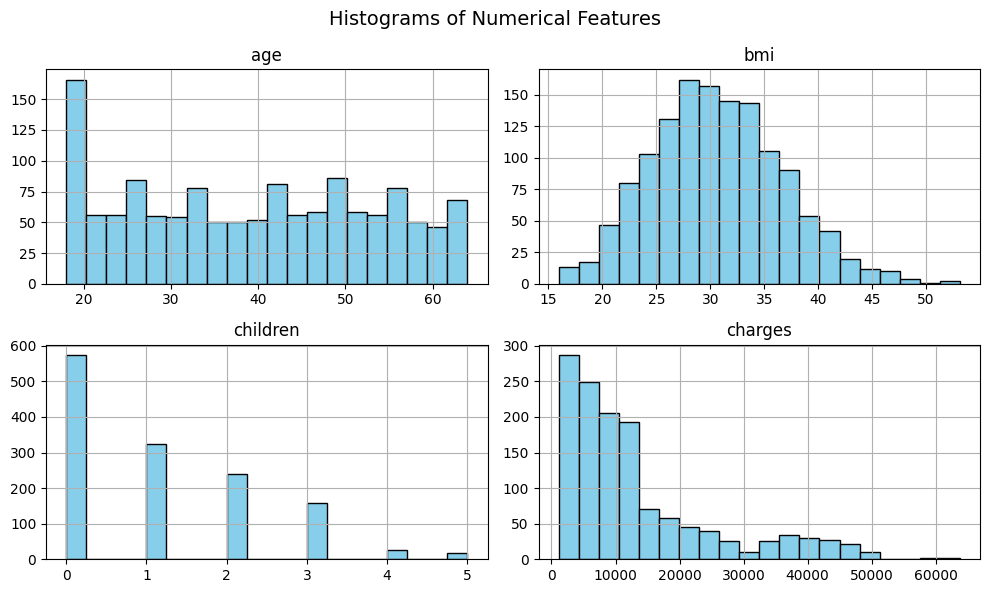

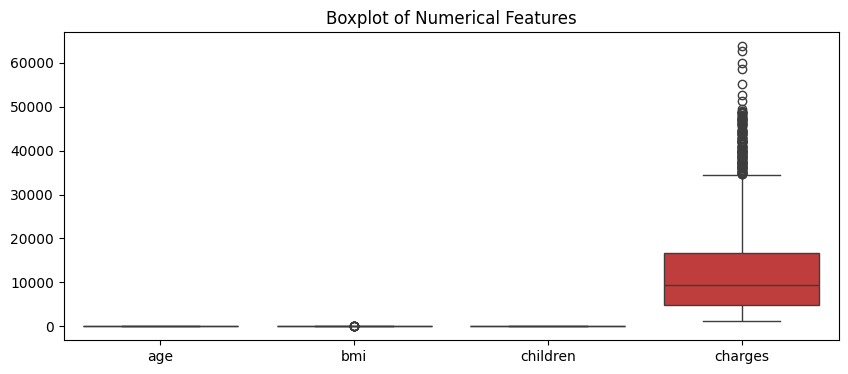

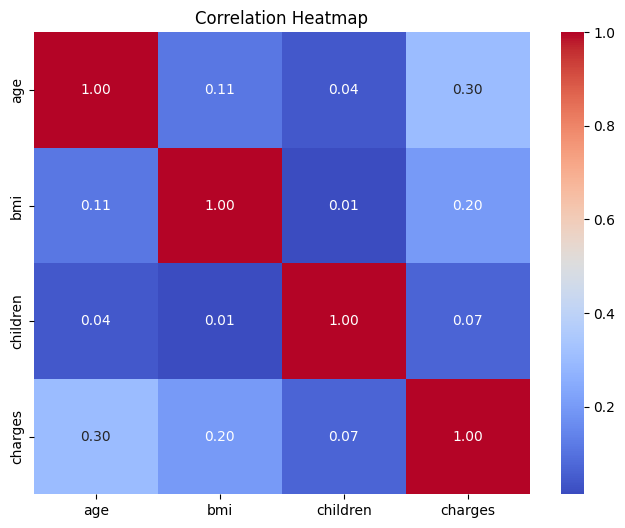

In [32]:
# Check for missing values
print("\n Missing Values:\n", df.isnull().sum())

# Basic statistics
print("\n Statistical Summary:")
display(df.describe())

# Check data types
print("\n Data Types:\n", df.dtypes)

# Visualize distribution of numerical features
numerical_features = ['age', 'bmi', 'children', 'charges']
df[numerical_features].hist(bins=20, figsize=(10, 6), layout=(2, 2), color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

# Boxplots to check for outliers
plt.figure(figsize=(10, 4))
sns.boxplot(data=df[numerical_features])
plt.title("Boxplot of Numerical Features")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Step 4: Data Preprocessing

Here I have performed preprocessing steps to prepare the dataset for both regression and classification tasks. It begins by checking for missing values, then encodes categorical columns like sex, smoker, and region using LabelEncoder which converts them into numeric form. I have also created a new binary classification target variable called high_cost, where entries are labeled 1 if their charges are above the median else 0. The code then selects relevant features which are age, sex, bmi, children, smoker, region and scales them using StandardScaler to normalize their values for better model performance. Finally I splitted the data into 80 % training and 20 % test.

In [33]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

# Encode categorical features
df_encoded = df.copy()
label_encoders = {}

for col in ['sex', 'smoker', 'region']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Create classification target: high_cost (1 if charges > median)
median_charge = df_encoded['charges'].median()
df_encoded['high_cost'] = (df_encoded['charges'] > median_charge).astype(int)

# Features for both models
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

# Scale features
scaler = StandardScaler()
df_encoded[features] = scaler.fit_transform(df_encoded[features])

# Define regression and classification targets
X = df_encoded[features]
y_reg = df_encoded['charges']
y_clf = df_encoded['high_cost']

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

df_encoded.head()

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,age,sex,bmi,children,smoker,region,charges,high_cost
0,-1.438764,-1.010519,-0.453320,-0.908614,1.970587,1.343905,16884.92400,1
1,-1.509965,0.989591,0.509621,-0.078767,-0.507463,0.438495,1725.55230,0
2,-0.797954,0.989591,0.383307,1.580926,-0.507463,0.438495,4449.46200,0
3,-0.441948,0.989591,-1.305531,-0.908614,-0.507463,-0.466915,21984.47061,1
4,-0.513149,0.989591,-0.292556,-0.908614,-0.507463,-0.466915,3866.85520,0


### Step 5: Baseline Models

### Step 5.1: Baseline Regression Model

I have used a baseline model Linear Regression. I have trained the mode on training data and predicted the values on test data. MSE values are large because the prediction we are doing is a large number and MSE squares the error which makes it a large number.
Here we can see the R² is 0.78 which means model explains the 78 % of variance of the target variable, which is good for a baseline model

In [34]:
  print("\n Training baseline Linear Regression model")

# Baseline Regression Model
baseline_reg = LinearRegression()
baseline_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = baseline_reg.predict(X_test_reg)

# Evaluate Regression
mse = mean_squared_error(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("Baseline Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")


 Training baseline Linear Regression model
Baseline Regression Results:
Mean Squared Error (MSE): 33635210.43
Mean Absolute Error (MAE): 4186.51
R² Score: 0.7833


### Step 5.2: Baseline Classification Model

I have used a baseline model Logistic Regression for classification. I have trained the mode on training data and predicted the values on test data. The accuracy of the model is 91 % which shows the model did well, aslo looking at precision and recall the overall performance of the model is good.
From the confusion matrix we can see we have 131 (TN), 15 (FP), 9 (FN) and 113 (TP).

In [35]:
print("\n Training baseline Logistic Regression model")

# Baseline Classification Model
baseline_clf = LogisticRegression(max_iter=1000)
baseline_clf.fit(X_train_clf, y_train_clf)
y_pred_clf = baseline_clf.predict(X_test_clf)

# Evaluate Classification
acc = accuracy_score(y_test_clf, y_pred_clf)
prec = precision_score(y_test_clf, y_pred_clf)
rec = recall_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf)

print("Baseline Classification Results:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test_clf, y_pred_clf)
print("\nConfusion Matrix:")
print(conf_matrix)


 Training baseline Logistic Regression model
Baseline Classification Results:
Accuracy: 0.9104
Precision: 0.8828
Recall: 0.9262
F1 Score: 0.9040

Confusion Matrix:
[[131  15]
 [  9 113]]


### Step 6: Deep Learning Model

### Step 6.1: Deep Learning Model For Regression

Here I have build a deep neural network for a regression task using tensorflow and keras. First I have constructed a Sequential model with two hidden layers the first with layer have 64 neurons and a 0.3 dropout, and the second layer have with 32 neurons and a 0.2 dropout both layers are using ReLU activation. The output layer has a single neuron with no activation because we are predicting continuous values. The model is compiled with the Adam optimizer, MSE as the loss function, and MAE as a performance metric. I have also integrated early stopping to prevent overfitting by stoping training process if validation loss doesn’t improve for 10 epochs. The model is then trained on the training set and validated on the test set, running for up to 100 epochs with a batch size of 32. Towards the end I have plotted the trainng and validation lossover epochs using a line plot to assess model convergence and overfitting.


 Building Deep Neural Network for REGRESSION...
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 336550944.0000 - mae: 13616.8926 - val_loss: 323362944.0000 - val_mae: 12966.0127
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 337283968.0000 - mae: 13822.0605 - val_loss: 323244576.0000 - val_mae: 12961.8721
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 298305664.0000 - mae: 12968.5420 - val_loss: 322999200.0000 - val_mae: 12953.7197
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 328554304.0000 - mae: 13626.2344 - val_loss: 322534016.0000 - val_mae: 12939.2266
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 300074752.0000 - mae: 12912.2217 - val_loss: 321763616.0000 - val_mae: 12916.1904
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 318452032.0000 - mae: 13035.2227 - val_loss: 320512800.0000 - val_mae: 12880.8613
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 320176864.0000 - mae: 13161.5264 - val_loss: 

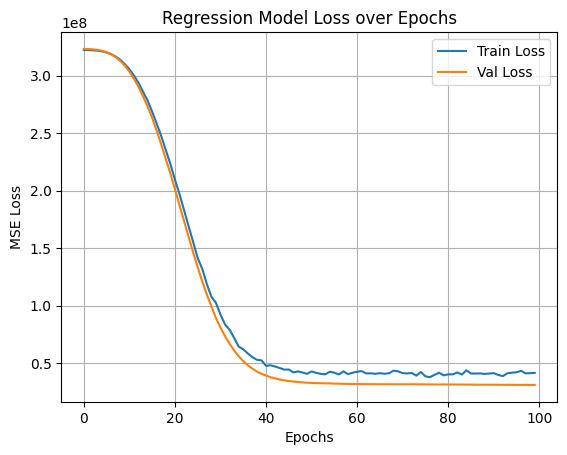

In [36]:
print("\n Building Deep Neural Network for REGRESSION...")

# Build model
reg_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_reg.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer with 1 node for regression
])

reg_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callback to stop early if val_loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_reg = reg_model.fit(
    X_train_reg, y_train_reg,
    validation_data=(X_test_reg, y_test_reg),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\n Training complete. Final Training and Validation Losses:")

# Plot training history
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Val Loss')
plt.title('Regression Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

### Step 6.2: Deep Learning Model for Classification

Here I build a deep neural network for a binary classification task using Keras. It is a Sequential model with two hidden layers, the first layer with 64 neurons and a 0.3 dropout, and the second layer with 32 neurons and a 0.2 dropout, both using ReLU activation to capture non-linear patterns. The output layer uses a single neuron with a sigmoid activation, appropriate for binary classification which outputs a probability between 0 and 1. The model is compiled using the Adam optimizer, with binary crossentropy as the loss function and accuracy as the evaluation metric. It uses the same early_stop callback from earlier to halt training if the validation loss doesn’t improve for 10 consecutive epochs. The model is trained on the classification training set and validated on the test set for up to 100 epochs, with a batch size of 32. After training, two plots are generated one showing the training and validation loss over epochs (to evaluate convergence and overfitting), and another showing the training and validation accuracy trends over time. After 48 epoch early stopping was trigerred as there was no imporvement in the loss.


 Building Deep Neural Network for CLASSIFICATION
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.6055 - loss: 0.6601 - val_accuracy: 0.8881 - val_loss: 0.5414
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8182 - loss: 0.5305 - val_accuracy: 0.9179 - val_loss: 0.3842
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8651 - loss: 0.4104 - val_accuracy: 0.9179 - val_loss: 0.2888
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8821 - loss: 0.3428 - val_accuracy: 0.9216 - val_loss: 0.2505
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8951 - loss: 0.3037 - val_accuracy: 0.9254 - val_loss: 0.2355
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8934 - loss: 0.2885 - val_accuracy: 0.9291 - val_loss: 0.2246
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9093 - loss: 0.2726 - val_accuracy: 0.9366 - val_loss: 0.2152
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accurac

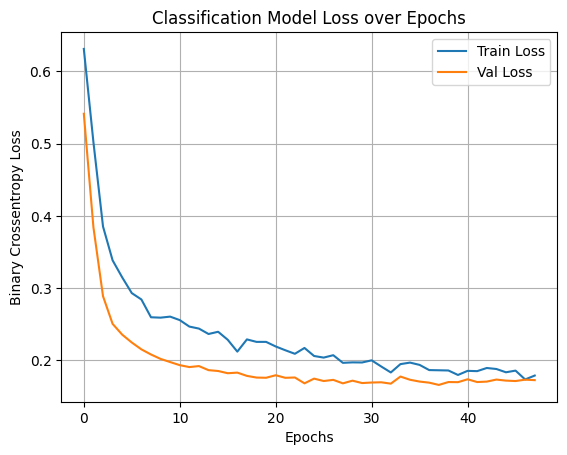

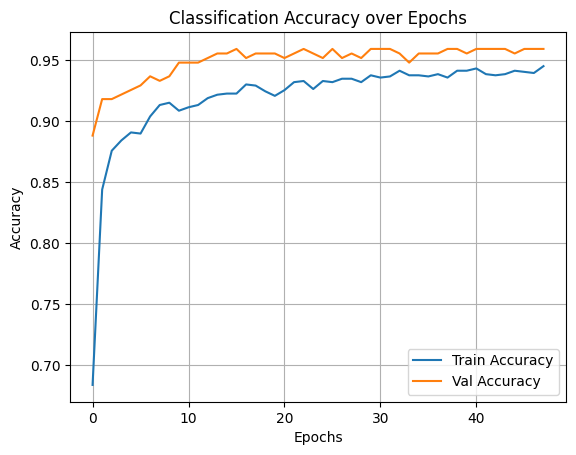

In [37]:
print("\n Building Deep Neural Network for CLASSIFICATION")

# Build model
clf_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_clf.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history_clf = clf_model.fit(
    X_train_clf, y_train_clf,
    validation_data=(X_test_clf, y_test_clf),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("Training complete. Final Training and Validation accuracy/loss:")

# Plot training history
plt.plot(history_clf.history['loss'], label='Train Loss')
plt.plot(history_clf.history['val_loss'], label='Val Loss')
plt.title('Classification Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_clf.history['accuracy'], label='Train Accuracy')
plt.plot(history_clf.history['val_accuracy'], label='Val Accuracy')
plt.title('Classification Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Step 7: Cross Validation

### Step 7.1: K-Fold Cross-Validation for REGRESSION

Here I have implemented K Flod Cross-Validation for regression I have used 5 folds, here I have created the same model which i created above for regression but this time I have added a K Fold for separating the data into 5 randomly shuffled folds. In every fold, the model is trained on 4/5 of the data and tested on the remaining 1/5, which also have early stopping for stopping the training if the validation loss is not better for 5 epochs. Having trained, the model makes the predictions in the validation fold, and MSE, MAE are calculated and recorded.

In [38]:
print("\n Performing 5-Fold Cross-Validation for REGRESSION model")

def build_reg_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores, mae_scores = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")
    X_train_k, X_val_k = X.iloc[train_idx], X.iloc[val_idx]
    y_train_k, y_val_k = y_reg.iloc[train_idx], y_reg.iloc[val_idx]

    model = build_reg_model()
    model.fit(X_train_k, y_train_k, epochs=50, batch_size=32,
              validation_data=(X_val_k, y_val_k),
              verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    preds = model.predict(X_val_k).flatten()
    mse_scores.append(mean_squared_error(y_val_k, preds))
    mae_scores.append(mean_absolute_error(y_val_k, preds))

print("\n Fold Regression Results:")
print(f"Mean MSE: {np.mean(mse_scores):.2f} ± {np.std(mse_scores):.2f}")
print(f"Mean MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")


 Performing 5-Fold Cross-Validation for REGRESSION model
Fold 1
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Fold 2
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 3
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold 4
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

 Fold Regression Results:
Mean MSE: 36760719.12 ± 3621408.85
Mean MAE: 4110.39 ± 143.65


### Step 7.2: K-Fold Cross-Validation for CLASSIFICATION

Here I have implemented K Flod Cross-Validation for classification I have used 5 folds, here I have created the same model which i created above for classification but this time I have added a K Fold for separating the data into 5 randomly shuffled folds. In every fold, the model is trained on 4/5 of the data and tested on the remaining 1/5, which also have early stopping for with (patience of 5 epochs on validation loss. The predictions are thresholded at 0.5 to convert probabilities into binary labels. For each fold, the accuracy and F1 score are calculated and stored. And then it calculates mean and standard deviation of accuracy and F1 scores across all 5 folds, providing a reliable estimate of the models classification performance and its consistency across different data splits.

In [39]:
print("\n Performing 5-Fold Cross-Validation for CLASSIFICATION model")

def build_clf_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

acc_scores, f1_scores = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")
    X_train_k, X_val_k = X.iloc[train_idx], X.iloc[val_idx]
    y_train_k, y_val_k = y_clf.iloc[train_idx], y_clf.iloc[val_idx]

    model = build_clf_model()
    model.fit(X_train_k, y_train_k, epochs=50, batch_size=32,
              validation_data=(X_val_k, y_val_k),
              verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    preds = (model.predict(X_val_k).flatten() > 0.5).astype(int)
    acc_scores.append(accuracy_score(y_val_k, preds))
    f1_scores.append(f1_score(y_val_k, preds))

print("\n K-Fold Classification Results:")
print(f"Mean Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")


 Performing 5-Fold Cross-Validation for CLASSIFICATION model
Fold 1
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fold 2
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Fold 3
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 4
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 K-Fold Classification Results:
Mean Accuracy: 0.9424 ± 0.0199
Mean F1 Score: 0.9406 ± 0.0186


### Step 8: Evaluation & Comparison

### Step 8.1: Final Evaluation for REGRESSION

Here i have evaluated the performace for the baseline and the Deep Neural Network that I created. It is very clear from the result that the DNN has performed better. Looking at all the metrics MSE, MAE and R² DNN have better metrics which indicates It reduces both MSE and MAE, meaning its predictions are closer to the actual values. It has a higher R² indicating it explains more variance in the target variableand overall this indicates that the DNN is a better fit for the regression task compared to the baseline, with improved accuracy and generalization.

In [40]:
print("\n Evaluating Deep Learning Regression model")

# Predict using trained DNN
y_pred_dnn_reg = reg_model.predict(X_test_reg).flatten()

# Compute metrics
mse_dnn = mean_squared_error(y_test_reg, y_pred_dnn_reg)
mae_dnn = mean_absolute_error(y_test_reg, y_pred_dnn_reg)
r2_dnn = r2_score(y_test_reg, y_pred_dnn_reg)

print("\n Deep Learning Regression Results:")
print(f"MSE: {mse_dnn:.2f}")
print(f"MAE: {mae_dnn:.2f}")
print(f"R² Score: {r2_dnn:.4f}")

# Print comparison table
print("\n Regression Comparison (Baseline vs DNN):")
print(f"{'Metric':<10} | {'Baseline':<12} | {'DNN':<12}")
print(f"{'-'*38}")
print(f"{'MSE':<10} | {mse:.2f}  | {mse_dnn:.2f}")
print(f"{'MAE':<10} | {mae:.2f}      | {mae_dnn:.2f}")
print(f"{'R²':<10} | {r2:.4f}       | {r2_dnn:.4f}")


 Evaluating Deep Learning Regression model
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

 Deep Learning Regression Results:
MSE: 31022003.67
MAE: 3843.71
R² Score: 0.8002

 Regression Comparison (Baseline vs DNN):
Metric     | Baseline     | DNN         
--------------------------------------
MSE        | 33635210.43  | 31022003.67
MAE        | 4186.51      | 3843.71
R²         | 0.7833       | 0.8002


### Step 8.2: Final Evaluation for CLASSIFICATION

I have evaluated the performace of the basline logistic regression and Deep Neural network for the classification task. We can clearly see the DNN performed better than our baseline model.

DNN Model: It achieved impressive metrics—Accuracy: 0.9590, Precision: 0.9826, Recall: 0.9262, and F1 Score: 0.9536. The confusion matrix shows the model correctly classified 144 true negatives and 113 true positives, with minimal misclassifications (2 false positives, 9 false negatives).

Baseline Model: While solid, it lagged behind the DNN slightly—Accuracy: 0.9104, Precision: 0.8828, Recall: 0.9262 (same as DNN), and F1 Score: 0.9040.

In [41]:
print("\n Evaluating Deep Learning Classification model")

# Predict using DNN
y_pred_dnn_clf = (clf_model.predict(X_test_clf).flatten() > 0.5).astype(int)

# Metrics
acc_dnn = accuracy_score(y_test_clf, y_pred_dnn_clf)
prec_dnn = precision_score(y_test_clf, y_pred_dnn_clf)
rec_dnn = recall_score(y_test_clf, y_pred_dnn_clf)
f1_dnn = f1_score(y_test_clf, y_pred_dnn_clf)

# Confusion Matrix
cm_dnn = confusion_matrix(y_test_clf, y_pred_dnn_clf)

print("\n Deep Learning Classification Results:")
print(f"Accuracy:  {acc_dnn:.4f}")
print(f"Precision: {prec_dnn:.4f}")
print(f"Recall:    {rec_dnn:.4f}")
print(f"F1 Score:  {f1_dnn:.4f}")
print("\nConfusion Matrix:")
print(cm_dnn)

# Print comparison table
print("\n Classification Comparison (Baseline vs DNN):")
print(f"{'Metric':<10} | {'Baseline':<12} | {'DNN':<12}")
print(f"{'-'*38}")
print(f"{'Accuracy':<10} | {acc:.4f}       | {acc_dnn:.4f}")
print(f"{'Precision':<10} | {prec:.4f}       | {prec_dnn:.4f}")
print(f"{'Recall':<10} | {rec:.4f}       | {rec_dnn:.4f}")
print(f"{'F1':<10} | {f1:.4f}       | {f1_dnn:.4f}")


 Evaluating Deep Learning Classification model
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

 Deep Learning Classification Results:
Accuracy:  0.9590
Precision: 0.9826
Recall:    0.9262
F1 Score:  0.9536

Confusion Matrix:
[[144   2]
 [  9 113]]

 Classification Comparison (Baseline vs DNN):
Metric     | Baseline     | DNN         
--------------------------------------
Accuracy   | 0.9104       | 0.9590
Precision  | 0.8828       | 0.9826
Recall     | 0.9262       | 0.9262
F1         | 0.9040       | 0.9536


### Step 8.3: Regression Comparison Plot

I have defined a function to show a bar chart which represents a comparison between Baseline Simple Linear Regression and Deep Neural Network

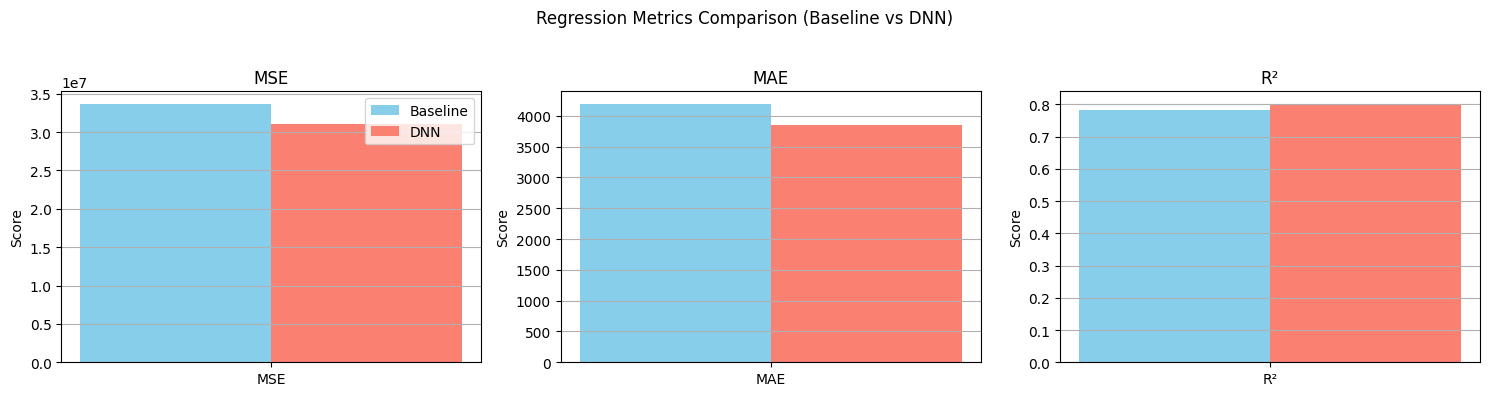

In [42]:
def plot_regression_comparisons_horizontally(metrics, baseline_scores, dnn_scores):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

    colors = ['skyblue', 'salmon']
    width = 0.3
    x = np.arange(1)

    for i, ax in enumerate(axes):
        ax.bar(x - width/2, [baseline_scores[i]], width, label='Baseline', color=colors[0])
        ax.bar(x + width/2, [dnn_scores[i]], width, label='DNN', color=colors[1])
        ax.set_title(metrics[i])
        ax.set_xticks(x)
        ax.set_xticklabels([metrics[i]])
        ax.set_ylabel("Score")
        ax.grid(axis='y')
        if i == 0:
            ax.legend()

    plt.suptitle("Regression Metrics Comparison (Baseline vs DNN)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()

# Providing the metric names and the corresponding scores
metrics = ['MSE', 'MAE', 'R²']
baseline_scores = [mse, mae, r2]
dnn_scores = [mse_dnn, mae_dnn, r2_dnn]

# Calling the plotting function
plot_regression_comparisons_horizontally(metrics, baseline_scores, dnn_scores)

### Step 8.4: Classification Comparison Plot

Here I have a bar chart representation for comparison between Baseline Logistic Regression and Deep Neural Network

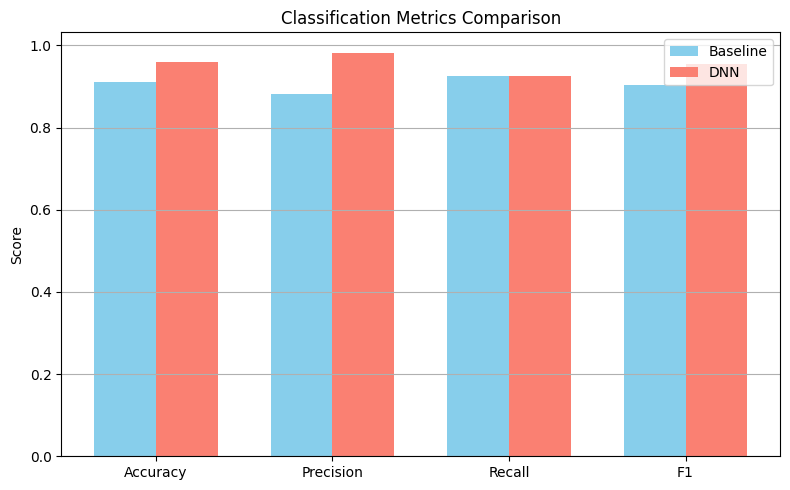

In [44]:
# Metrics
classification_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
baseline_clf_scores = [acc, prec, rec, f1]
dnn_clf_scores = [acc_dnn, prec_dnn, rec_dnn, f1_dnn]

x = np.arange(len(classification_metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_clf_scores, width, label='Baseline', color='skyblue')
plt.bar(x + width/2, dnn_clf_scores, width, label='DNN', color='salmon')

plt.ylabel('Score')
plt.title('Classification Metrics Comparison')
plt.xticks(x, classification_metrics)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()